# WINGS Quickstart: Basic Functionality Verification

This notebook verifies that the core WINGS functionality works correctly.

**Tests covered:**
- Package import and backend detection
- Configuration creation
- Optimizer initialization
- Statevector computation
- Fidelity calculation
- Gradient computation
- Basic optimization run
- Result visualization

## 0. Setup: Path Configuration

**Option A (Recommended):** Install the package first:
```bash
cd gaussian_state_optimizer
pip install -e .
```

**Option B:** Run the cell below to auto-detect and add the source to Python path.

In [1]:
# ============================================================================
# FRESH START - Run this FIRST after kernel restart
# ============================================================================
import sys
from pathlib import Path

# Clean up sys.path - remove any gaussian_state_optimizer paths
sys.path = [p for p in sys.path if 'gaussian_state_optimizer' not in p and 'optimization' not in p]

# Add the correct path
src_path = Path.cwd() / 'optimization-files' / 'src'
sys.path.insert(0, str(src_path))

print("sys.path (first 3):")
for p in sys.path[:3]:
    print(f"  {p}")

# Now verify the package exists at that location
init_file = src_path / 'gaussian_state_optimizer' / '__init__.py'
print(f"\n__init__.py exists: {init_file.exists()}")

if init_file.exists():
    print(f"✓ Package found at: {src_path / 'gaussian_state_optimizer'}")
else:
    print(f"✗ Package NOT found. Check your directory structure.")
    print(f"  Looking for: {init_file}")

sys.path (first 3):
  /home/jmc03846/WINGS_debug/optimization-files/src
  /home/jmc03846/WINGS_debug
  

__init__.py exists: True
✓ Package found at: /home/jmc03846/WINGS_debug/optimization-files/src/gaussian_state_optimizer


In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import time
import os

print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Working directory: {os.getcwd()}")

# Now import
from gaussian_state_optimizer import GaussianOptimizer, OptimizerConfig, TargetFunction
print("✓ Import successful!")

Python version: 3.11.3 (main, Apr  8 2025, 20:57:06) [GCC 12.3.0]
NumPy version: 2.2.6
Working directory: /home/jmc03846/WINGS_debug
Detected HPC scratch directory: /scratch/jmc03846
Created/verified directory: /home/jmc03846/lib
Created/verified directory: /scratch/jmc03846/coefficient_cache
Created/verified directory: /scratch/jmc03846/simulation_output
Created/verified directory: /scratch/jmc03846/simulation_data
Created/verified directory: /scratch/jmc03846/optimization_checkpoints
Created/verified directory: /scratch/jmc03846/optimization_campaigns
✓ Import successful!


## 1. Package Import and Backend Detection

In [3]:
# Test imports
try:
    from gaussian_state_optimizer import (
        GaussianOptimizer,
        OptimizerConfig,
        TargetFunction,
    )
    print("✓ Core imports successful")
    
    # Optional imports
    try:
        from gaussian_state_optimizer import __version__
        print(f"✓ Version: {__version__}")
    except ImportError:
        print("⚠ __version__ not defined (optional)")
    
    try:
        from gaussian_state_optimizer import get_backend_info, print_backend_info
        print("✓ Backend info functions available")
    except ImportError:
        print("⚠ get_backend_info not defined (will use manual detection)")
        get_backend_info = None
        print_backend_info = None

except ImportError as e:
    print(f"✗ Import failed: {e}")
    print(f"\nDebug - sys.path includes:")
    for p in sys.path[:5]:
        print(f"  {p}")
    raise

✓ Core imports successful
✓ Version: 0.1.0
✓ Backend info functions available


In [4]:
# Check available backends
if print_backend_info:
    print_backend_info()
else:
    print("Manual backend detection:")

# GPU (Qiskit Aer)
try:
    from qiskit_aer import AerSimulator
    backend = AerSimulator(method='statevector')
    has_gpu = 'GPU' in str(backend.available_devices())
    print(f"  Qiskit Aer GPU: {'✓' if has_gpu else '✗'}")
except Exception as e:
    print(f"  Qiskit Aer GPU: ✗")
    has_gpu = False

# cuStateVec
try:
    import cupy as cp
    from cuquantum.bindings import custatevec as cusv
    handle = cusv.create()
    cusv.destroy(handle)
    has_custatevec = True
    print(f"  cuStateVec: ✓")
except:
    print(f"  cuStateVec: ✗")
    has_custatevec = False

Gaussian State Optimizer - Backend Information
  CPU (Qiskit Statevector): ✓ Available
  GPU (Qiskit Aer):         ✓ Available
  cuStateVec:               ✓ Available
  Qiskit Aer GPU: ✓
  cuStateVec: ✓


## 2. Configuration Creation

In [5]:
# Test basic configuration
config = OptimizerConfig(
    n_qubits=6,
    sigma=0.5,
    box_size=4.0,
    verbose=True,
    use_gpu=False,
    use_custatevec=False,
)

print(f"\n✓ Configuration created")
print(f"  n_qubits: {config.n_qubits}")
print(f"  n_params: {config.n_params}")
print(f"  n_states: {config.n_states}")
print(f"  sigma: {config.sigma}")
print(f"  box_size: ±{config.box_size}")
print(f"  delta_x: {config.delta_x:.6f}")

Using user-specified box size: +/-4.00
Target function: gaussian
Parallelization: 63 workers, backend='thread'

✓ Configuration created
  n_qubits: 6
  n_params: 36
  n_states: 64
  sigma: 0.5
  box_size: ±4.0
  delta_x: 0.126984


In [6]:
# Verify computed properties
assert config.n_params == config.n_qubits ** 2, f"n_params mismatch"
assert config.n_states == 2 ** config.n_qubits, f"n_states mismatch"
assert len(config.positions) == config.n_states, f"positions length mismatch"

print("✓ All configuration properties verified")

✓ All configuration properties verified


## 3. Optimizer Initialization

In [7]:
# Create optimizer
optimizer = GaussianOptimizer(config)

print(f"✓ Optimizer created")
print(f"  n_params: {optimizer.n_params}")
print(f"  n_evals: {optimizer.n_evals}")
print(f"  best_fidelity: {optimizer.best_fidelity}")

✓ Optimizer created
  n_params: 36
  n_evals: 0
  best_fidelity: 0


In [8]:
# Verify target wavefunction
target = optimizer.target

print(f"Target wavefunction:")
print(f"  Shape: {target.shape}")
print(f"  Dtype: {target.dtype}")
print(f"  Norm: {np.linalg.norm(target):.10f}")

assert target.shape == (config.n_states,)
assert np.isclose(np.linalg.norm(target), 1.0, atol=1e-10)

print("\n✓ Target wavefunction verified")

Target wavefunction:
  Shape: (64,)
  Dtype: complex128
  Norm: 1.0000000000

✓ Target wavefunction verified


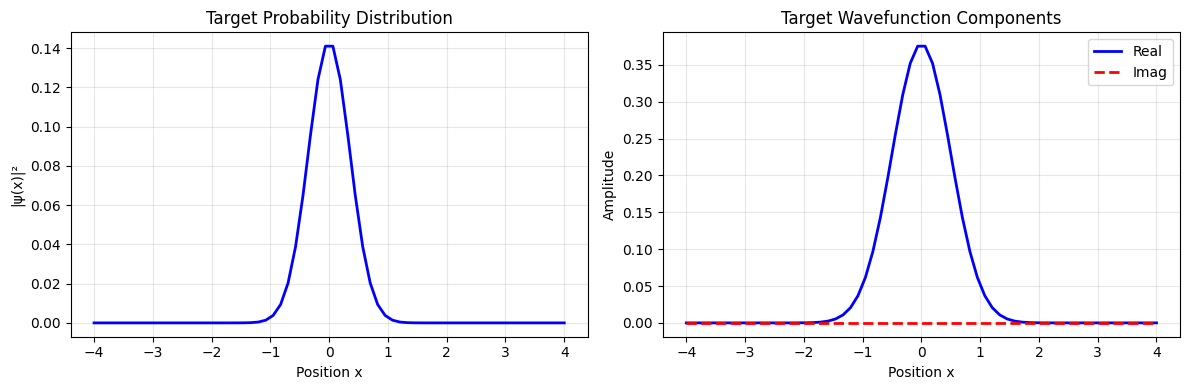

In [9]:
# Plot target wavefunction
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

x = optimizer.positions

axes[0].plot(x, np.abs(target)**2, 'b-', linewidth=2)
axes[0].set_xlabel('Position x')
axes[0].set_ylabel('|ψ(x)|²')
axes[0].set_title('Target Probability Distribution')
axes[0].grid(True, alpha=0.3)

axes[1].plot(x, target.real, 'b-', label='Real', linewidth=2)
axes[1].plot(x, target.imag, 'r--', label='Imag', linewidth=2)
axes[1].set_xlabel('Position x')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Target Wavefunction Components')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Statevector Computation

In [10]:
# Test statevector computation
np.random.seed(42)
test_params = np.random.randn(config.n_params) * 0.1

start = time.perf_counter()
sv = optimizer.get_statevector(test_params)
elapsed = time.perf_counter() - start

print(f"Statevector computation:")
print(f"  Time: {elapsed*1000:.2f} ms")
print(f"  Shape: {sv.shape}")
print(f"  Norm: {np.linalg.norm(sv):.10f}")

assert sv.shape == (config.n_states,)
assert np.isclose(np.linalg.norm(sv), 1.0, atol=1e-10)

print("\n✓ Statevector computation verified")

Statevector computation:
  Time: 3.12 ms
  Shape: (64,)
  Norm: 1.0000000000

✓ Statevector computation verified


## 5. Fidelity Calculation

In [11]:
# Test fidelity computation
fidelity = optimizer.compute_fidelity(params=test_params)

print(f"Fidelity: {fidelity:.10f}")
print(f"Infidelity: {1-fidelity:.6e}")

assert 0.0 <= fidelity <= 1.0
print("\n✓ Fidelity computation verified")

Fidelity: 0.1270268196
Infidelity: 8.729732e-01

✓ Fidelity computation verified


In [12]:
# Fidelity of target with itself should be 1.0
fid_target = optimizer._compute_fidelity_fast(optimizer.target)
print(f"Self-fidelity: {fid_target:.15f}")
assert np.isclose(fid_target, 1.0, atol=1e-10)
print("✓ Self-fidelity verified")

Self-fidelity: 1.000000000000000
✓ Self-fidelity verified


## 6. Gradient Computation

In [13]:
# Test gradient computation
print("Computing gradient...")

start = time.perf_counter()
gradient = optimizer.compute_gradient(test_params)
elapsed = time.perf_counter() - start

print(f"\nGradient computation:")
print(f"  Time: {elapsed:.2f} s")
print(f"  Shape: {gradient.shape}")
print(f"  Norm: {np.linalg.norm(gradient):.6f}")

assert gradient.shape == (config.n_params,)
assert np.all(np.isfinite(gradient))

print("\n✓ Gradient computation verified")

Computing gradient...

Gradient computation:
  Time: 0.21 s
  Shape: (36,)
  Norm: 0.312684

✓ Gradient computation verified


In [14]:
# Verify gradient against finite difference
eps = 1e-5
n_check = 3

print(f"Gradient verification (first {n_check} parameters):")
max_error = 0
for i in range(n_check):
    params_plus = test_params.copy(); params_plus[i] += eps
    params_minus = test_params.copy(); params_minus[i] -= eps
    
    fid_plus = optimizer.compute_fidelity(params=params_plus)
    fid_minus = optimizer.compute_fidelity(params=params_minus)
    
    fd_grad = -(fid_plus - fid_minus) / (2 * eps)
    error = abs(gradient[i] - fd_grad)
    max_error = max(max_error, error)
    
    print(f"  Param {i}: analytic={gradient[i]:.6f}, FD={fd_grad:.6f}, error={error:.2e}")

assert max_error < 1e-3
print(f"\n✓ Gradient matches finite difference (max error: {max_error:.2e})")

Gradient verification (first 3 parameters):
  Param 0: analytic=-0.012491, FD=-0.012491, error=4.27e-12
  Param 1: analytic=0.002103, FD=0.002103, error=4.23e-13
  Param 2: analytic=-0.108324, FD=-0.108324, error=2.96e-12

✓ Gradient matches finite difference (max error: 4.27e-12)


## 7. Basic Optimization Run

In [15]:
# Try to use OptimizationPipeline, fall back to scipy if not available
try:
    from gaussian_state_optimizer.config import OptimizationPipeline
    HAS_PIPELINE = True
    print("✓ OptimizationPipeline available")
except ImportError:
    HAS_PIPELINE = False
    print("⚠ OptimizationPipeline not available, using scipy directly")

✓ OptimizationPipeline available


In [16]:
# Run optimization
print("\nStarting optimization...\n")
start_time = time.time()

if HAS_PIPELINE:
    pipeline = OptimizationPipeline(
        target_fidelity=0.99,
        max_total_time=60,
        use_adam_stage=True,
        adam_max_steps=1000,
        verbose=True,
    )
    results = optimizer.run_optimization(pipeline)
else:
    from scipy.optimize import minimize
    
    np.random.seed(42)
    x0 = np.random.randn(config.n_params) * 0.1
    
    result = minimize(
        optimizer.objective,
        x0,
        method='L-BFGS-B',
        jac=lambda p: optimizer.compute_gradient(p),
        options={'maxiter': 500, 'disp': True},
    )
    
    results = {
        'fidelity': -result.fun,
        'optimal_params': result.x,
        'success': result.success,
        'n_evaluations': result.nfev,
        'time': time.time() - start_time,
    }

total_time = time.time() - start_time

print(f"\n{'='*60}")
print("OPTIMIZATION RESULTS")
print(f"{'='*60}")
print(f"  Final fidelity:   {results['fidelity']:.12f}")
print(f"  Infidelity (1-F): {1-results['fidelity']:.6e}")
print(f"  Time:             {results.get('time', total_time):.2f}s")


Starting optimization...


OPTIMIZATION PIPELINE: ADAPTIVE
  Target fidelity:   0.99
  Target infidelity: 1e-02
  Max time:          60s

STAGE: Initialization Search
  smart               : F = 0.16788189
  gaussian_product    : F = 0.00046017
  random              : F = 0.00314017
  random              : F = 0.00275114
  random              : F = 0.01822953

Best initialization: 'smart' with F = 0.16788189

STAGE: Adam Exploration
  Time budget: 600s

Adam Optimization (lr=0.01, max_steps=1000)
--------------------------------------------------
  Step     0: F=0.1678818927, |∇|=3.75e-01, lr=0.0100
  Step   100: F=0.9338807256, |∇|=1.13e-01, lr=0.0051
  Step   200: F=0.9577584688, |∇|=7.80e-02, lr=0.0100
  Step   300: F=0.9947533636, |∇|=1.45e-02, lr=0.0075
  Step   400: F=0.9980667312, |∇|=8.61e-03, lr=0.0027
  Step   500: F=0.9984139513, |∇|=7.57e-03, lr=0.0100
  Step   600: F=0.9994848745, |∇|=1.48e-03, lr=0.0089
  Step   700: F=0.9995612782, |∇|=7.73e-04, lr=0.0060
  Step   800: 

In [17]:
assert results['fidelity'] > 0.9, f"Fidelity too low: {results['fidelity']}"
print("✓ Optimization achieved F > 0.9")

✓ Optimization achieved F > 0.9


## 8. Result Visualization

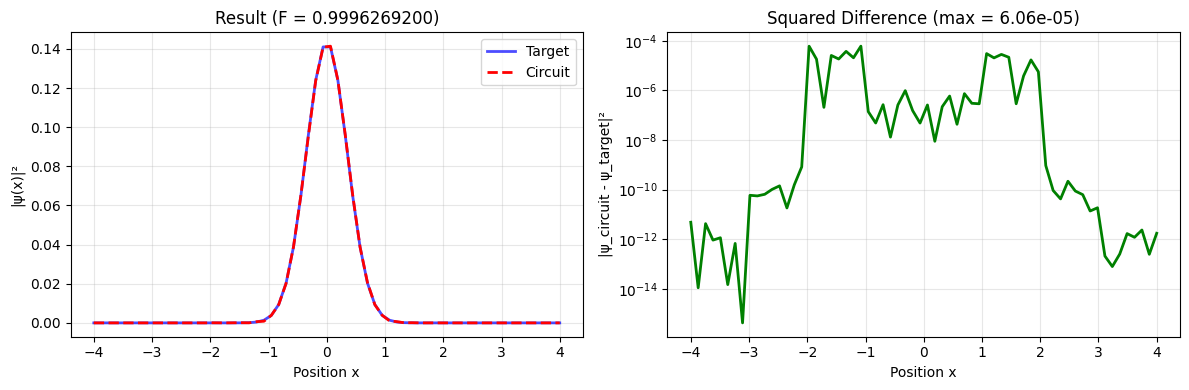

✓ Saved: quickstart_results.png


In [18]:
# Plot results
optimal_sv = optimizer.get_statevector(results['optimal_params'])
x = optimizer.positions

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Probability distributions
axes[0].plot(x, np.abs(optimizer.target)**2, 'b-', linewidth=2, label='Target', alpha=0.7)
axes[0].plot(x, np.abs(optimal_sv)**2, 'r--', linewidth=2, label='Circuit')
axes[0].set_xlabel('Position x')
axes[0].set_ylabel('|ψ(x)|²')
axes[0].set_title(f'Result (F = {results["fidelity"]:.10f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Difference
diff = np.abs(optimal_sv - optimizer.target)**2
axes[1].semilogy(x, diff + 1e-20, 'g-', linewidth=2)
axes[1].set_xlabel('Position x')
axes[1].set_ylabel('|ψ_circuit - ψ_target|²')
axes[1].set_title(f'Squared Difference (max = {diff.max():.2e})')
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('quickstart_results.png', dpi=150)
plt.show()

print("✓ Saved: quickstart_results.png")

## Summary

In [19]:
print("="*60)
print("QUICKSTART VERIFICATION SUMMARY")
print("="*60)
print("\n✓ Package imports")
print("✓ Configuration creation")
print("✓ Optimizer initialization")
print("✓ Statevector computation")
print("✓ Fidelity calculation")
print("✓ Gradient computation")
print("✓ Optimization run")
print("✓ Result visualization")
print("\n" + "="*60)
print(f"Final fidelity: {results['fidelity']:.12f}")
print("ALL TESTS PASSED")
print("="*60)

QUICKSTART VERIFICATION SUMMARY

✓ Package imports
✓ Configuration creation
✓ Optimizer initialization
✓ Statevector computation
✓ Fidelity calculation
✓ Gradient computation
✓ Optimization run
✓ Result visualization

Final fidelity: 0.999626920043
ALL TESTS PASSED
